In [1]:
import numpy as np
import pandas as dp
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import os,random
import cv2
import csv

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D
from keras.optimizers import RMSprop,SGD,Adagrad
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pickle

Using TensorFlow backend.


In [4]:
#load image data from file and labels
#load labels
# define 8 kind of emotion,defined as one hot label
# anger-1    contempt-2    disgust-3   fear-4   happiness-5   neutral-6     sadness-7    surprise-8
def labelconvert():
    csv_file=csv.reader(open('train.csv','r'))
    x=list(csv_file)
    length=len(x)
    onehot_labels=np.zeros((length,8))
    labels=np.zeros((length))
    for i in range (0,len(x)):
        if (x[i][1]=='anger'):
            onehot_labels[i][0]=1
            labels[i]=0
        elif (x[i][1]=='contempt'):
            onehot_labels[i][1]=1
            labels[i]=1
        elif (x[i][1]=='disgust'):
            onehot_labels[i][2]=1
            labels[i]=2
        elif (x[i][1]=='fear'):
            onehot_labels[i][3]=1
            labels[i]=3
        elif (x[i][1]=='happiness'):
            onehot_labels[i][4]=1
            labels[i]=4
        elif (x[i][1]=='neutral'):
            onehot_labels[i][5]=1
            labels[i]=5
        elif (x[i][1]=='sadness'):
            onehot_labels[i][6]=1
            labels[i]=6
        elif (x[i][1]=='surprise'):
            onehot_labels[i][7]=1
            labels[i]=7
        else:
            labels[i]=0
    return onehot_labels,labels

#load images data
DATA_DIR='C:\\Users\\zhang\\Desktop\\EE599 coding\\HW4\\train_image\\'

ROWS = 224
COLS = 224
CHANNELS = 1

all_images = [DATA_DIR+i for i in os.listdir(DATA_DIR)] # use this for full dataset
#test_images =  [DATA_DIR+i for i in os.listdir(DATA_DIR) if i>=10000]


def read_image(file_path):
    img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count,  ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%2000 == 0: print('Processed Row Data{} of {}'.format(i, count))
    
    return data

# get all data and labels, image data in 'data' array ,onehot labels in 'labels', number labels in 'num_labels'

data= prep_data(all_images)
labels,num_labels=labelconvert()

print("Data shape: {}".format(data.shape))

Processed Row Data0 of 12993
Processed Row Data2000 of 12993
Processed Row Data4000 of 12993
Processed Row Data6000 of 12993
Processed Row Data8000 of 12993
Processed Row Data10000 of 12993
Processed Row Data12000 of 12993
Data shape: (12993, 224, 224)


In [12]:
np.savez_compressed('image_data.npz',data,labels)

In [6]:
# brief understanding of data
average_fig=data.sum(axis=0)/data.shape[0]
#plt.imshow(average_fig,cmap='gray')
#plt.title('average face')
#plt.show()
labels.sum(axis=0)

array([ 239.,    8.,  197.,   19., 5408., 6520.,  253.,  349.])

In [7]:
# data prepocessing
#include train/validaiton data seperation, balance data and augment data

# train/validation seperate
n_train=8000
n_validation=1000

train, val, train_labels, val_labels = train_test_split(data, labels, train_size=n_train,test_size=n_validation)
print("Train shape: {}".format(train.shape))
print('train labels distribution',train_labels.sum(axis=0))
print("Validation shape: {}".format(val.shape))
print('test labels distribution',val_labels.sum(axis=0))
# data augmentation


train_data=train.reshape(n_train,224,224,1)
val_data=val.reshape(n_validation,224,224,1)
#print(train_data.shape)
#sns.countplot(train_labels)
#sns.plttitle('Cats and Dogs')

Train shape: (8000, 224, 224)
train labels distribution [ 138.    6.  127.   16. 3325. 3999.  163.  226.]
Validation shape: (1000, 224, 224)
test labels distribution [ 29.   0.  10.   0. 400. 516.  17.  28.]


In [8]:
# show image
anger= np.array([1,0,0,0,0,0,0,0])
contempt= np.array([0,1,0,0,0,0,0,0])    
disgust= np.array([0,0,1,0,0,0,0,0])   
fear= np.array([0,0,0,1,0,0,0,0])    
happiness= np.array([0,0,0,0,1,0,0,0])    
neutral= np.array([0,0,0,0,0,1,0,0])      
sadness= np.array([0,0,0,0,0,0,1,0])     
surprise= np.array([0,0,0,0,0,0,0,1]) 

def show_face(dataset):
    img = dataset
    plt.imshow(img,cmap='gray')
    plt.show()

def show_face_compared(dataset1,idx1,dataset2,idx2):
    img1=dataset1[idx1]
    img2=dataset2[idx2]
    pair = np.concatenate((img1, img2), axis=1)
    plt.figure(figsize=(8,4))
    plt.imshow(pair,cmap='gray')
    plt.show()

def show_label(label_test):
    if (label_test==anger).all():
        print('anger')
    elif (label_test==contempt).all():
        print('contempt')
    elif (label_test==disgust).all():
        print('disgust')
    elif (label_test==fear).all():
        print('fear')
    elif (label_test==happiness).all():
        print('happiness')
    elif (label_test==neutral).all():
        print('neutral')
    elif (label_test==sadness).all():
        print('sadness')
    elif (label_test==surprise).all():
        print('surprise')
    else:
        print('error')
    
### an example of figure show and label show    
#for idx in range(0,1):
#    show_face_compared(data,idx,train,idx)
#    print(labels[idx],train_labels[idx])
#    show_label(labels[idx])
#    show_label(train_labels[idx])

In [9]:

# use VGG-16 to train model
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'

def model_VGG_16():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(ROWS, COLS,1), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(8))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


def model_me():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS,1), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
#    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(8))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

def model_simple():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(ROWS, COLS,1), activation='relu'))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(8))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = model_VGG_16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [10]:
nb_epoch = 40
batch_size = 20
#cla_weights= class_weight.compute_class_weight('balanced',np.unique(num_labels),num_labels)
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_facial():
    
    history = LossHistory()
    model.fit(train_data, train_labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
              #validation_split=0.25, verbose=0, shuffle=True, callbacks=[history],class_weight=cla_weights)
    

    #predictions = model.predict(test, verbose=0)
    return history

def run_facial_balance():
    history = LossHistory()
    model.fit(train_new, train_labels_new, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
              #validation_split=0.25, verbose=0, shuffle=True, callbacks=[history],class_weight=cla_weights)
    

    #predictions = model.predict(test, verbose=0)
    return history


In [11]:
# train model
history = run_facial()
show_lost_fig()

KeyboardInterrupt: 

In [ ]:
def show_lost_fig():
    loss = history.losses
    val_loss = history.val_losses

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('my model Loss Trend')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0,nb_epoch)[0::2])
    plt.legend()
    plt.show()

In [ ]:
val_predictions = model.predict(val_data, verbose=0)
train_predictions=model.predict(train_data,verbose=0)
all_predictions=model.predict(data.reshape(12993,224,224,1),verbose=0)
#test_predictions=model.predict(test,verbose=0)

In [ ]:
# test performance on test set(seperate of training part)
# a full understanding of model accuracy and classfication

def notsure(predictions):
    n_notsure=0
    for i in range (0,len(predictions)):
        if (predictions[i]<0.7 and predictions[i]>0.3):
            n_notsure+=1
    notsure_per=n_notsure/len(predictions)
    return notsure_per

def get_hot_value(prediction_list):
    hot_list=np.zeros((prediction_list.shape[0],prediction_list.shape[1]),int)
    for i in range (0,len(prediction_list)):
        max_val, hot_oneline, max_found = max(prediction_list[i]), [], False
        for item in prediction_list[i]:
            if item == max_val and not max_found:
                hot_oneline.append(1)
                max_found = True
            else:
                hot_oneline.append(0)
        hot_list[i,:]=hot_oneline
    return hot_list

def detail(label,predictions):
    n_right=0
    n_wrong=0
    pred_onehot=get_hot_value(predictions)
    n_wrongclassified=np.zeros((predictions.shape[1]),int) #classified as a label(in predictions), but is not
    n_rightclassified=np.zeros((predictions.shape[1]),int)
    n_allclassified=pred_onehot.sum(axis=0)
    n_alllabeled=label.sum(axis=0)
    for i in range (0,len(predictions)):
        if (label[i]==pred_onehot[i]).all():
            n_right+=1
            n_rightclassified+=pred_onehot[i]
        else:
            n_wrong+=1
            n_wrongclassified+=pred_onehot[i]
    accuracy=n_right/len(predictions)
    return accuracy,n_wrongclassified,n_rightclassified,n_allclassified,n_alllabeled.astype(int)

In [ ]:
## all detail in this model
acc_all,n_wrc,n_ric,n_allc,n_alll=detail(labels,all_predictions)
print('detail of all image')
print('wrong prediction of each label',n_wrc)
print('right prediction of each label',n_ric)
print('prediction of each label      ',n_allc)
print('true of each label            ',n_alll)
print('the total accuracy is %f'%(acc_all))
print('')

## validation detail in this model
accu=detail(val_labels,val_predictions)
val_onehot=get_hot_value(val_predictions)
print('detail of test image')
print('the test accuracy is %f'%(accu[0]))
print('')

acc_train,train_wrc,train_ric,train_allc,train_alll=detail(train_labels,train_predictions)
print('detail of training image')
print('for training accuracy is %f' %acc_train)
print('wrong prediction of train label',train_wrc)
print('right prediction of train label',train_ric)
print('prediction of train label      ',train_allc)
print('true of train label            ',train_alll)

In [16]:
##### balance data with generated new image of less class image
### from the data we find that 1,2,3,4,7,8 class are less than 5,6, among them, 2,4 are far less.
### to overcome inbalance data, we generate 1,3,7,8 each image into 20 other image, and we generate 2,4 each into 200 image.
with open('C:\\Users\\zhang\\Desktop\\EE599 coding\\HW4\\sep.txt', 'rb') as fp:   # Unpickling
    read_data = pickle.load(fp)
#use some data as an example to begain generating


In [17]:
anger=read_data[0]      # generate 5 times
anger_labels=np.tile(np.array([1,0,0,0,0,0,0,0]), (len(anger),1))
contempt=read_data[1]   # generate 100 times
contempt_labels=np.tile(np.array([0,1,0,0,0,0,0,0]), (len(contempt),1))
disgust=read_data[2]    # generate 5 times
disgust_labels=np.tile(np.array([0,0,1,0,0,0,0,0]), (len(disgust),1))
fear=read_data[3]       # generate 50 times
fear_labels=np.tile(np.array([0,0,0,1,0,0,0,0]), (len(fear),1))
happiness=read_data[4]  # get first 1500 data
happiness_labels=np.tile(np.array([0,0,0,0,1,0,0,0]), (len(happiness),1))
neutral=read_data[5]    # get first 1500 data
neutral_labels=np.tile(np.array([0,0,0,0,0,1,0,0]), (len(neutral),1))
sadness=read_data[6]    # generate 7 times
sadness_labels=np.tile(np.array([0,0,0,0,0,0,1,0]), (len(sadness),1))
surprise=read_data[7]   # generate 5 times
surprise_labels=np.tile(np.array([0,0,0,0,0,0,0,1]), (len(surprise),1))

In [18]:
datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')

def data_gene(input_data,input_labels,epoch):
    e=epoch
    batches=0
    gen_data=np.asarray(input_data).reshape(len(input_data),224,224,1)
    gen_labels=np.asarray(input_labels)
    for x_batch,y_batch in datagen.flow(input_data.reshape(len(input_data),224,224,1),input_labels, batch_size=len(input_data)):
#            model.fit(x_batch, y_batch)
            batches += 1
            gen_data=np.vstack([gen_data,x_batch])
            gen_labels=np.vstack([gen_labels,y_batch])
            if batches >= e:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
    return gen_data,gen_labels

(349, 224, 224)

In [161]:
# anger-1    contempt-2    disgust-3   fear-4   happiness-5   neutral-6     sadness-7    surprise-8
anger_new,anger_labels_new=data_gene(anger,anger_labels,5)
contempt_new,contempt_labels_new=data_gene(contempt,contempt_labels,100)
disgust_new,disgust_labels_new=data_gene(disgust,disgust_labels,5)
fear_new,fear_labels_new=data_gene(fear,fear_labels,50)
happiness_new,happiness_labels_new=happiness.reshape(len(happiness),224,224,1),happiness_labels
neutral_new,neutral_labels_new=neutral.reshape(len(neutral),224,224,1),neutral_labels
sadness_new,sadness_labels_new=data_gene(sadness,sadness_labels,7)
surprise_new,surprise_labels_new=data_gene(surprise,surprise_labels,5)

In [162]:
data_new=np.concatenate((anger_new,contempt_new,disgust_new,fear_new,happiness_new,neutral_new,sadness_new,surprise_new), axis=0)
labels_new=np.concatenate((anger_labels_new,contempt_labels_new,disgust_labels_new,fear_labels_new,happiness_labels_new,
                           neutral_labels_new,sadness_labels_new,surprise_labels_new), axis=0)

In [165]:
np.savez('gene_image.npz', data_new, labels_new)

array([1434,  808, 1182,  969, 4000, 4000, 2024, 2094])

In [169]:
#npzfile = np.load(outfile)
#npzfile.files
['arr_1', 'arr_0']
#npzfile['arr_0']

['arr_1', 'arr_0']

Epoch 00036: early stopping


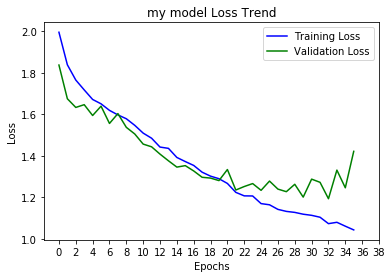

In [170]:
train_new, val_new, train_labels_new, val_labels_new = train_test_split(data_new, labels_new, train_size=n_train,test_size=n_validation)
history = run_facial_balance()
show_lost_fig()

In [171]:
val_predictions = model.predict(val_data, verbose=0)
train_predictions=model.predict(train_data,verbose=0)
all_predictions=model.predict(data.reshape(12993,224,224,1),verbose=0)
#test_predictions=model.predict(test,verbose=0)

In [172]:
## all detail in this model
acc_all,n_wrc,n_ric,n_allc,n_alll=detail(labels,all_predictions)
print('detail of all image')
print('wrong prediction of each label',n_wrc)
print('right prediction of each label',n_ric)
print('prediction of each label      ',n_allc)
print('true of each label            ',n_alll)
print('the total accuracy is %f'%(acc_all))
print('')

## validation detail in this model
accu=detail(val_labels,val_predictions)
print('detail of test image')
print('wrong prediction of each label',accu[1])
print('right prediction of each label',accu[2])
print('prediction of each label      ',accu[3])
print('true of each label            ',accu[4])
print('the test accuracy is %f'%(accu[0]))
print('')

detail of all image
wrong prediction of each label [ 30   0  32   1 663 694 437 397]
right prediction of each label [  27    0   34    1 4738 5635  129  175]
prediction of each label       [  57    0   66    2 5401 6329  566  572]
true of each label             [ 239    8  197   19 5408 6520  253  349]
the total accuracy is 0.826522

detail of test image
wrong prediction of each label [ 2  0  5  0 57 48 37 40]
right prediction of each label [  4   0   2   0 356 425   8  16]
prediction of each label       [  6   0   7   0 413 473  45  56]
true of each label             [ 19   0  20   2 407 506  18  28]
the test accuracy is 0.811000



In [174]:
model.save('model_balanced2.h5')